# LPSpline Demo

This notebook demonstrates how to use the `lpspline` package to build and optimize linear spline models using the additive API.

In [ ]:
import numpy as np
import polars as pl
try:
    import matplotlib.pyplot as plt
except ImportError:
    import os
    os.system('pip install matplotlib')
    import matplotlib.pyplot as plt
from lpspline import l, pwl, bs, cs, f

# Set seed for reproducibility
np.random.seed(42)

## 1. Generate Synthetic Data

We create a dataset with various non-linear relationships.

In [2]:
n = 200
x_linear = np.linspace(0, 10, n)
x_pwl = np.linspace(0, 10, n)
x_bs = np.linspace(0, 10, n)
x_cyc = np.linspace(0, 2*np.pi, n)
x_factor = np.random.randint(0, 3, n)

# True functions
y_linear = 0.5 * x_linear
y_pwl = np.where(x_pwl < 5, 0, x_pwl - 5) # Hinge at 5
y_bs = np.sin(x_bs) # Sine wave
y_cyc = np.cos(x_cyc) # Cosine wave
y_factor = np.array([0, 2, -1])[x_factor] # Categorical effects

# Combined target with noise
y = y_linear + y_pwl + y_bs + y_cyc + y_factor + np.random.normal(0, 0.2, n)

df = pl.DataFrame({
    "linear_col": x_linear,
    "pwl_col": x_pwl,
    "bs_col": x_bs,
    "cyc_col": x_cyc,
    "factor_col": x_factor,
    "target": y
})

print(df.head())

shape: (5, 6)
┌────────────┬──────────┬──────────┬──────────┬────────────┬───────────┐
│ linear_col ┆ pwl_col  ┆ bs_col   ┆ cyc_col  ┆ factor_col ┆ target    │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆ ---        ┆ ---       │
│ f64        ┆ f64      ┆ f64      ┆ f64      ┆ i64        ┆ f64       │
╞════════════╪══════════╪══════════╪══════════╪════════════╪═══════════╡
│ 0.0        ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 2          ┆ -0.132548 │
│ 0.050251   ┆ 0.050251 ┆ 0.050251 ┆ 0.031574 ┆ 0          ┆ 1.045563  │
│ 0.100503   ┆ 0.100503 ┆ 0.100503 ┆ 0.063148 ┆ 2          ┆ -0.020612 │
│ 0.150754   ┆ 0.150754 ┆ 0.150754 ┆ 0.094721 ┆ 2          ┆ 0.05658   │
│ 0.201005   ┆ 0.201005 ┆ 0.201005 ┆ 0.126295 ┆ 0          ┆ 1.509537  │
└────────────┴──────────┴──────────┴──────────┴────────────┴───────────┘


## 2. Define API and Model

We define the components and add them together to create the model.

In [ ]:
# Create model using additive syntax
model = (
    l(term='linear_col', bias=True)
    + pwl(term='pwl_col', knots=[5.])
    + bs(term="bs_col", knots=np.linspace(0, 10, 5), degree=3)
    + cs(term="cyc_col", period=2*np.pi, order=2)
    + f(term="factor_col", n_classes=3)
)

## 3. Fit the Model

We use the `fit` method on the combined model.

In [4]:
model.fit(df, df["target"])

print("Model fitted successfully.")


✨ Model Summary ✨
Problem Status: ✅ optimal
--------------------------------------------------
Spline Type          | Term            | Params    
--------------------------------------------------
🟢 Linear            | linear_col      | 2         
🟢 PiecewiseLinear   | pwl_col         | 3         
🟢 BSpline           | bs_col          | 1         
🟢 CyclicSpline      | cyc_col         | 5         
🟢 Factor            | factor_col      | 3         
--------------------------------------------------
📊 Total Parameters                    | 14        

Model fitted successfully.


## 4. Predict and Evaluate

We generate predictions and visualize the fit.

Mean Squared Error: 0.0416


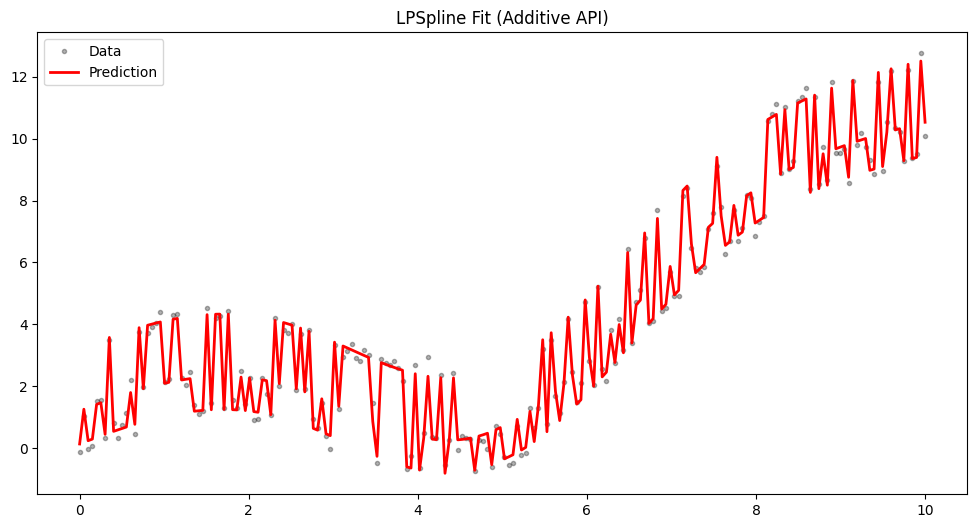

In [5]:
predictions = model.predict(df)
mse = np.mean((predictions - df["target"].to_numpy())**2)
print(f"Mean Squared Error: {mse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["linear_col"], df["target"], 'k.', alpha=0.3, label='Data')
plt.plot(df["linear_col"], predictions, 'r-', linewidth=2, label='Prediction')
plt.legend()
plt.title("LPSpline Fit (Additive API)")
plt.show()

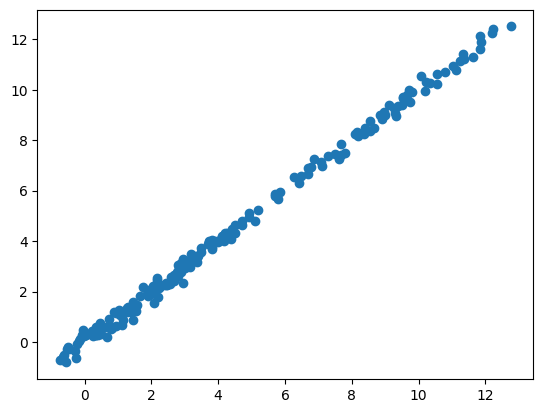

In [6]:
plt.scatter(df['target'], predictions)

## 5. Visualize Spline Components

We can also visualize the individual effect of each spline component.

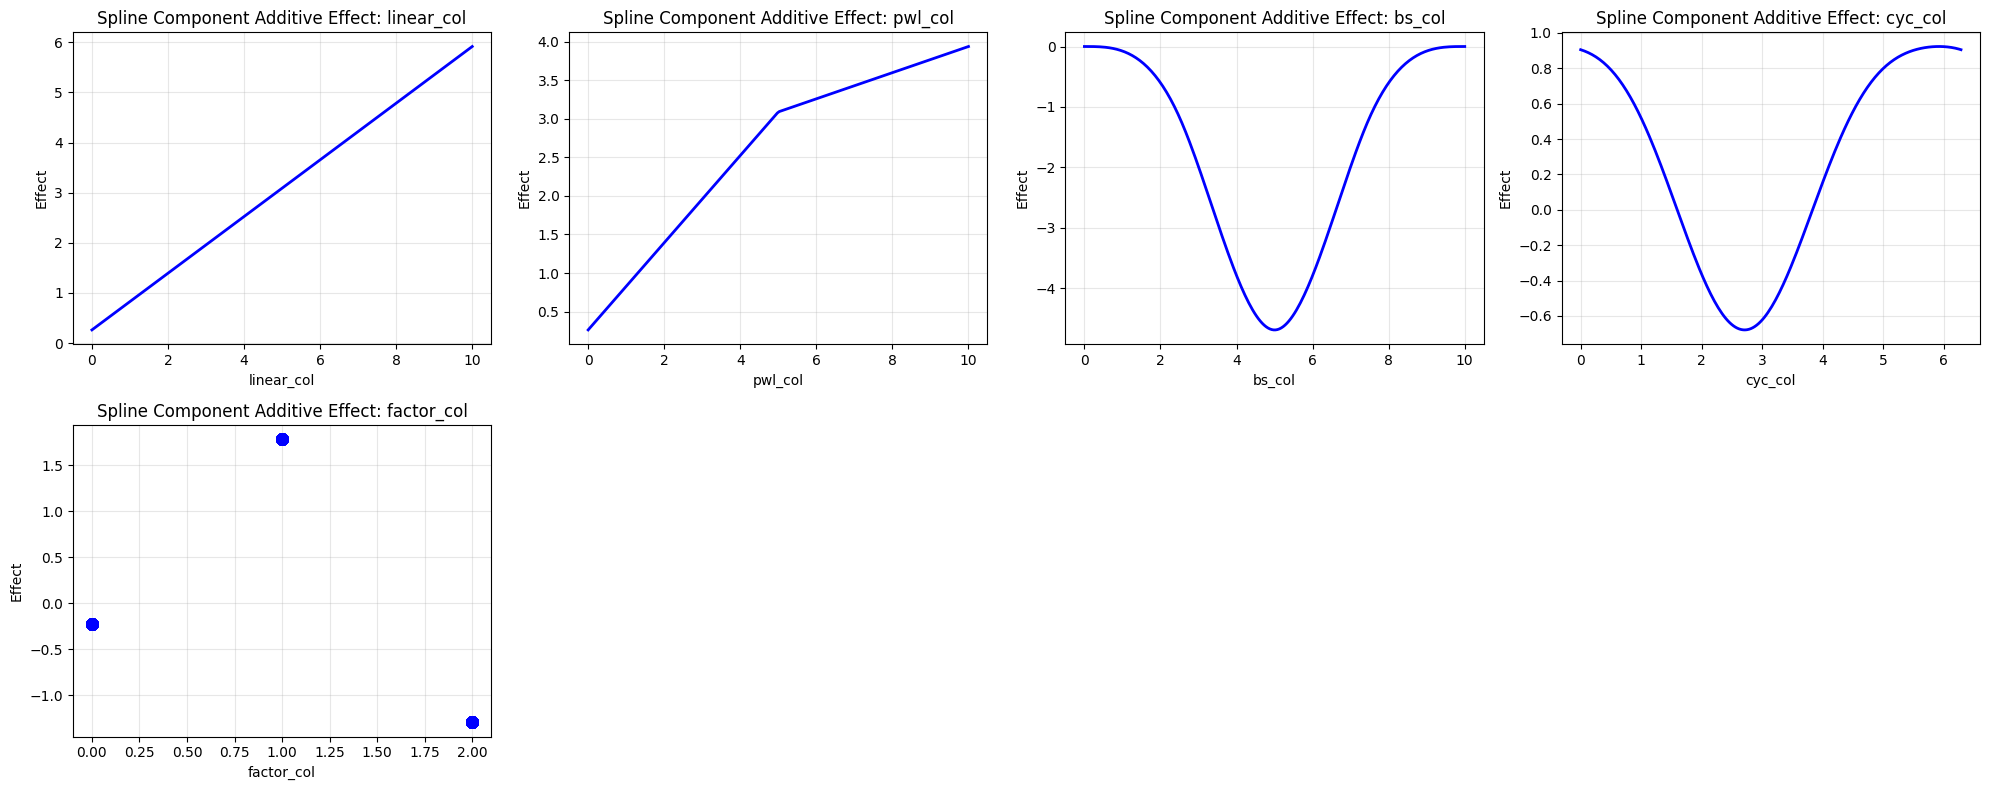

In [7]:
components = model.predict(df, return_components=True)

n_splines = len(model.splines)
n_cols = 4
n_rows = int(np.ceil(n_splines / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

# In case subplots returns a single Axes object (e.g. n_rows=1, n_cols=1),
# or a 1D array (e.g. n_rows=1, n_cols=4). We can safely use np.atleast_1d and flatten.
if isinstance(axes, plt.Axes):
    axes = np.array([axes])
axes = axes.flatten()

for i, spline in enumerate(model.splines):
    feature = spline.term
    x_vals = df[feature].to_numpy()
    comp_vals = components[:, i]
    
    # Sort for plotting lines nicely
    idx = np.argsort(x_vals)
    
    # If categorical, scatter plot might be better, but plot with markers works
    if len(np.unique(x_vals)) < 10:
        axes[i].plot(x_vals[idx], comp_vals[idx], 'bo', markersize=8)
    else:
        axes[i].plot(x_vals[idx], comp_vals[idx], 'b-', linewidth=2)
        
    axes[i].set_title(f"Spline Component Additive Effect: {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Effect")
    axes[i].grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(n_splines, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()